In [0]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import array_ops
import numpy as np
import matplotlib.pyplot as plt
import processes
from processes import orstein_uhlenbeck as ou
import utils
from utils import kalman
import buildingblocks
from buildingblocks import stupidcell

/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Network

In [0]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [0]:

graph=tf.Graph()


In [0]:
logs_dir = './graphs/'
batch_size=128
num_steps=1095
lstm_layers= 1
lstm_size= 64
inputs_dim= 1
alpha = 0.1

In [0]:
with graph.as_default():
    inputs_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='inputs')
    targets_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='targets')
    learning_rate= tf.placeholder( tf.float32 , name='lr')
    keep_prob= tf.placeholder( tf.float32 , name='keep_prob')
    grad_clip= tf.placeholder( tf.float32 , name='clip')

In [0]:

with graph.as_default():
    cell = stupidcell.StupidRNNCell(1,activation= None)
    
    '''
    stupidlstm = stupidcell.StupidLSTMCell(lstm_size)
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    lstm= tf.contrib.rnn.MultiRNNCell([lstm,stupidlstm])
    '''
    lstm =tf.contrib.rnn.BasicLSTMCell(lstm_size)
    lstm = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    lstm2 = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    lstm2 = tf.nn.rnn_cell.DropoutWrapper(lstm2, output_keep_prob=keep_prob)
    lstm =  tf.contrib.rnn.MultiRNNCell([lstm,lstm2])
    W = tf.Variable(tf.random_normal([lstm_size, lstm_size]), dtype=tf.float32) # weights
    b = tf.Variable(tf.random_normal([ lstm_size]), dtype=tf.float32)
    def residual_wrapper( i,o):
        '''
        out = tf.matmul( o, W)+b
        out = tf.sigmoid( out)
        return array_ops.concat([i,out],1)
        '''
        return array_ops.concat([i,o],1)
    lstm = tf.contrib.rnn.ResidualWrapper( lstm, residual_wrapper) 
    
    rnn_cell = tf.contrib.rnn.MultiRNNCell([lstm,cell])
# 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]

# defining initial state
    initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)

# 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(rnn_cell, inputs_,
                                   initial_state=initial_state,
                                   dtype=tf.float32)
    '''
    W = tf.Variable(tf.random_normal([lstm_size, inputs_dim]), dtype=tf.float32) # weights
    b = tf.Variable(tf.random_normal([ inputs_dim]), dtype=tf.float32) # biases
    shape = outputs.shape
    
    outputs = tf.matmul( tf.reshape( outputs, [-1, lstm_size]), W ) + b
    outputs = tf.reshape( outputs, (shape[0],shape[1],b.shape[0]))
    '''


(128, 2)


In [0]:
with graph.as_default():
    square=  tf.reduce_mean( tf.square( outputs - targets_),axis=0 )
    shape = square.shape
    square = tf.reshape(square, [shape[0],])
    def power(x):
        alpha =0.96
        return (1-alpha)*tf.pow(alpha,x)
    weights = tf.map_fn(  power, tf.range( start= shape[0]-1, delta=-1., limit= -0.5  ) )
    cost = tf.losses.compute_weighted_loss( square, weights )
    optimizer= build_optimizer(cost, learning_rate, grad_clip)
    

## Batch

In [0]:


def batch_1( batch_size, num_steps, noise, dictionary,):
    while True:
        invariant_std = 0.5 
        rand = np.random.rand()
        lbd = 10**( (np.random.randint(2) -0.5 )*2 ) # 0.1 10
        sigma = invariant_std*np.sqrt(2*lbd)
        dictionary['sigma'] = sigma
        dictionary['lbd'] = lbd

        batch = np.random.randn( batch_size,num_steps+1,1)*noise
        trend =np.reshape( ou.process(**dictionary)[: num_steps+1] , [-1,1] )
        for i in range(batch_size):
            batch[i,:,:]=batch[i,:,:]+trend[:,:]
        
        yield (batch[:,:-1,:] , batch[:,1:,:],trend, dictionary )

    

In [0]:
invariant_std = 0.2
lbd = 1.
sigma = invariant_std*np.sqrt(2*lbd)
start= 365
dictionary = {'deltaT': 1./365,
              'T':3}
noise= 0.1/np.sqrt( dictionary['deltaT'])
generator1 = batch_1( batch_size , num_steps,noise ,dictionary)

In [0]:
generator= generator1

## Training

## Batch 1

In [0]:
run=False

{'Iteration:  99 \\/ 3000'}
-3.6465810358989996


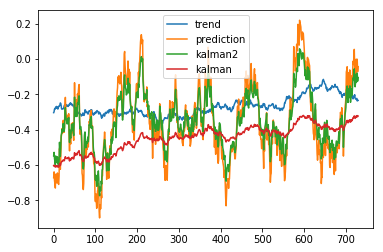

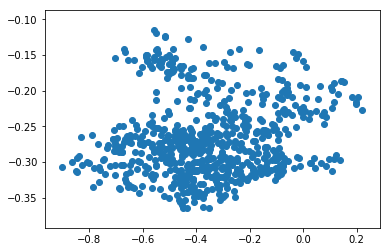

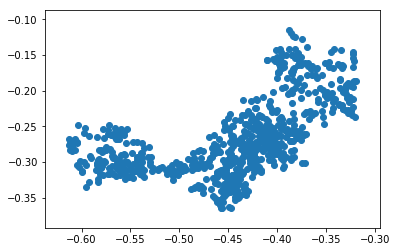

{'Iteration:  199 \\/ 3000'}
-3.6466162573546184


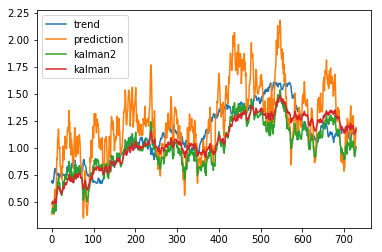

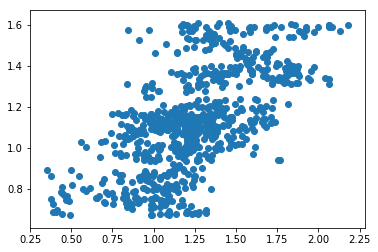

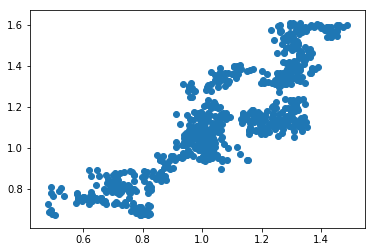

{'Iteration:  299 \\/ 3000'}
-3.6461628874298198


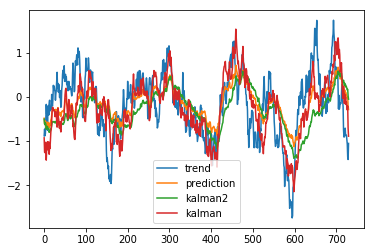

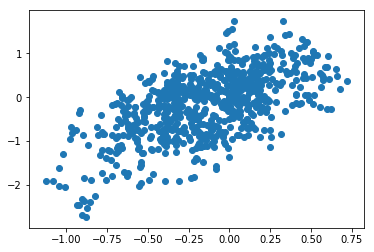

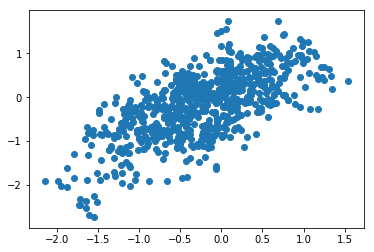

{'Iteration:  399 \\/ 3000'}
-3.646605964843185


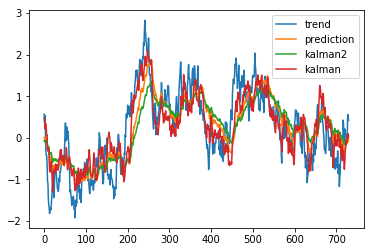

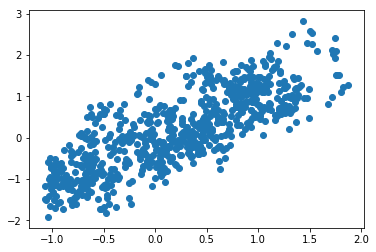

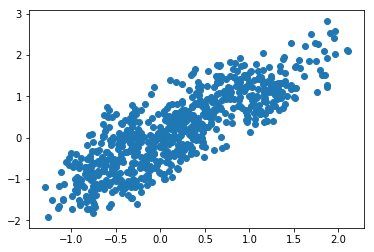

{'Iteration:  499 \\/ 3000'}
-3.64659653264098


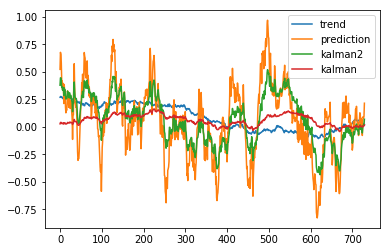

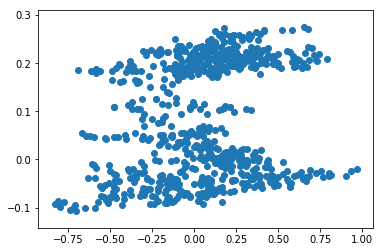

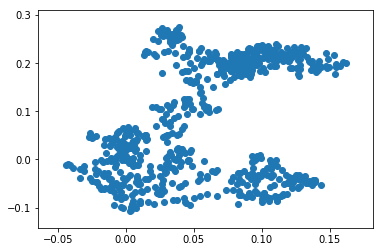

{'Iteration:  599 \\/ 3000'}
-3.646673714835198


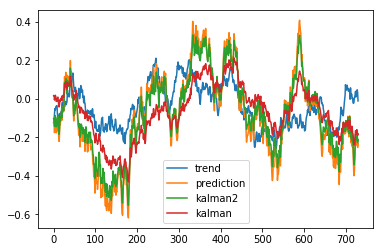

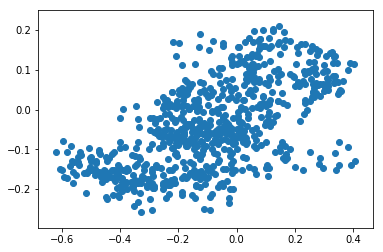

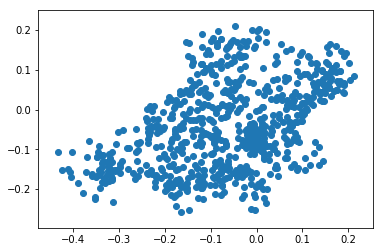

{'Iteration:  699 \\/ 3000'}
-3.646500481385739


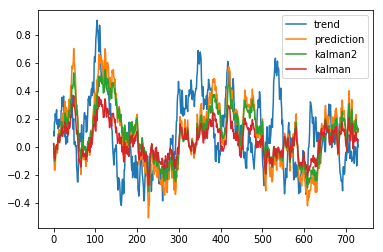

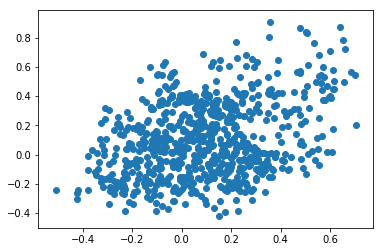

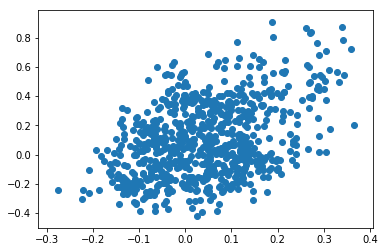

{'Iteration:  799 \\/ 3000'}
-3.6465953312348587


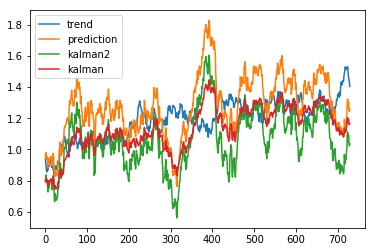

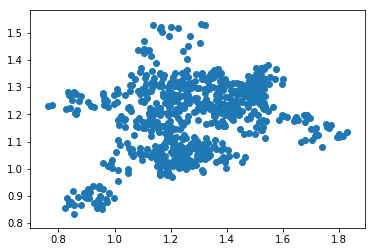

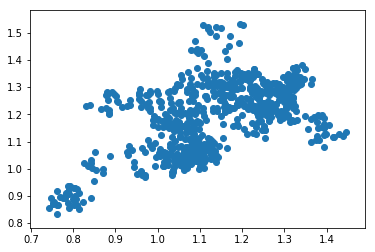

{'Iteration:  899 \\/ 3000'}
-3.646471077669413


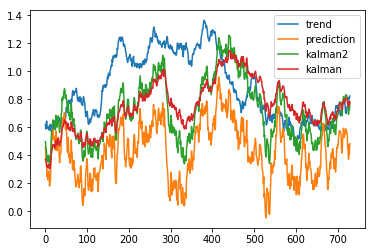

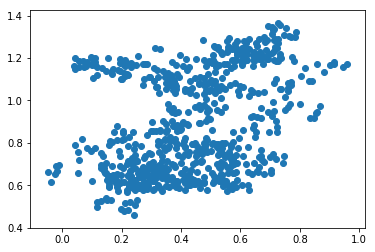

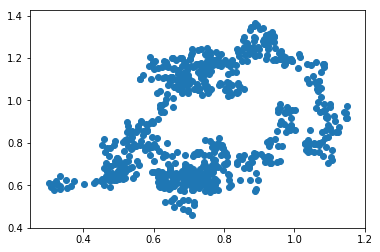

{'Iteration:  999 \\/ 3000'}
-3.6463122005574418


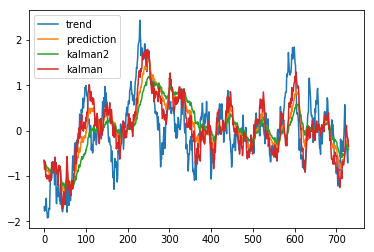

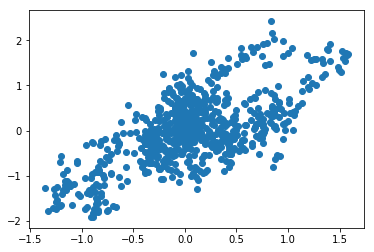

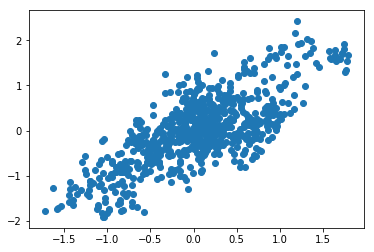

{'Iteration:  1099 \\/ 3000'}
-3.646656285831706


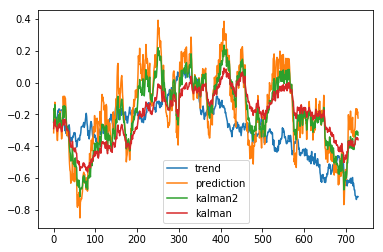

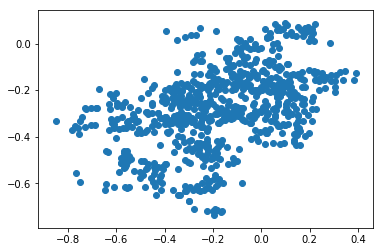

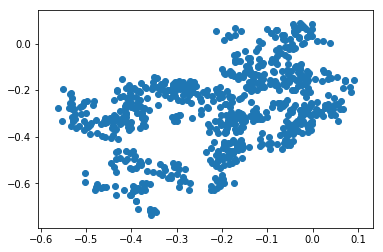

{'Iteration:  1199 \\/ 3000'}
-3.6466071189846856


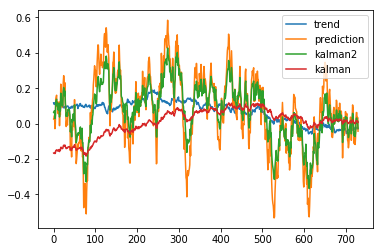

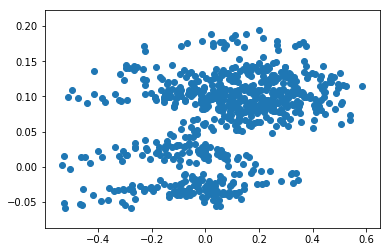

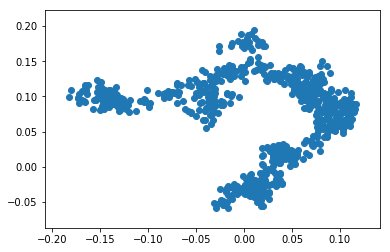

In [0]:
logs_dir= './graphs/approximative33/'
save_dir= logs_dir+'model.ckpt'
writer = tf.summary.FileWriter(logs_dir, graph)

lrate = 0.001
N= 3000
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    if not run :
        sess.run(tf.global_variables_initializer())
        run= True
    else:
        saver.restore(sess, save_dir)
    for i in range(N):
        X,Y ,trends, dicti= next(generator)
        state = sess.run( initial_state)

    
        
        if i==1000:
            lrate /= 10.
        '''
        if i==2000:
            lrate /= 3.
        '''
        feed = { inputs_: X,
                initial_state :state,
               targets_: Y ,
               learning_rate: lrate,
               grad_clip: 0.1,
               keep_prob: 1. }
        if (i+1) %100 == 0 :
            index=0
            print( { 'Iteration:  {} \/ {}'.format(i,N)})
            result = sess.run( [cost, outputs], feed_dict=feed)
            print( result[0]-noise**2)
            plt.plot( trends[1:,0][start:], label='trend')
            plt.plot( result[1][index,:,0][start:] , label='prediction')

            lbd = 1
            sigma = 0.9
            sigmaS= 0.1
            deltaT= 1./365
            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                             sigmaS =sigmaS ,
                                             lbd=lbd,
                                             sigmamu= sigma,
                                             deltaT=deltaT )
            plt.plot(kalman_result[start:], label='kalman2' )

            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                                    sigmaS =noise/np.sqrt(365.) ,
                                                    lbd=dicti['lbd'],
                                                    sigmamu= dicti['sigma'],
                                                    deltaT=dicti['deltaT'] )
            plt.plot(kalman_result[start:], label='kalman' )
            plt.legend( loc='best')
            plt.show()
            plt.scatter( result[1][index,start:,0], trends[1:,0][start:])
            plt.show()
            plt.scatter( kalman_result[start:], trends[1:,0][start:])
            plt.show()
        feed[keep_prob]= 0.50
        sess.run( [optimizer], feed_dict=feed)
        if (i+1)%500 == 0 :
            save_path= saver.save(sess, save_dir)
        ## print result
    for i in range(20):
        X,Y ,trends, dicti= next(generator)
        state = sess.run( initial_state)
        feed = { inputs_: X,
                initial_state :state,
               targets_: Y ,
               learning_rate: 0.001,
               grad_clip: 0.1,
               keep_prob:1.}
        if i> -1 :
            result = sess.run( [cost, outputs], feed_dict=feed)
            index=0
            print( result[0]-noise**2)
            plt.plot( trends[1:,0][start:], label='trend')
            plt.plot( result[1][index,:,0][start:] , label='prediction')

            
            lbd = 1
            sigma = 0.9
            sigmaS= 0.1
            deltaT= 1./365
            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                             sigmaS =sigmaS ,
                                             lbd=lbd,
                                             sigmamu= sigma,
                                             deltaT=deltaT )
            plt.plot(kalman_result[start:], label='kalman2' )

            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                                    sigmaS =noise/np.sqrt(365.) ,
                                                    lbd=dicti['lbd'],
                                                    sigmamu= dicti['sigma'],
                                                    deltaT=dicti['deltaT'] )
            plt.plot(kalman_result[start:], label='kalman' )
            plt.legend( loc='best')
            plt.show()
            plt.scatter( result[1][index,start:,0], trends[1:,0][start:])
            plt.show()
            plt.scatter( kalman_result[start:], trends[1:,0][start:])
            plt.show()
        

writer.close()   

In [0]:
index=0
lbd = 1
sigma = 0.9
sigmaS= 0.1
deltaT= 1./365
dicti['sigma'] = 0.3
kalman_coeff1 =  kalman.kalman_coeff(sigmaS =sigmaS ,
                                    lbd=lbd,
                                    sigmamu= sigma,
                                    deltaT=deltaT )
kalman_coeff2 =  kalman.kalman_coeff(sigmaS =noise/np.sqrt(365.) ,
                                    lbd=dicti['lbd'],
                                    sigmamu= dicti['sigma'],
                                    deltaT=dicti['deltaT'] )
print( kalman_coeff1)
print(kalman_coeff2)


In [0]:
kalman_result

In [0]:
dicti

In [0]:
index=0
lbd = 1
sigma = 0.9
sigmaS= 0.1
deltaT= 1./365
kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                 sigmaS =sigmaS ,
                                 lbd=lbd,
                                 sigmamu= sigma,
                                 deltaT=deltaT )
plt.plot(kalman_result, label='kalman' )
#plt.plot(X[index,:,0])
plt.plot( result[1][index,:,0] , label = 'prediction')
plt.plot( trends[1:,0] , label= 'truth')
plt.legend( loc='best')
plt.show()

In [0]:
plt.scatter( result[1][0,:,0], trends[1:,0])
plt.show()

In [0]:
plt.plot(Y[0,:,0])
plt.show()